In [3]:
import earthaccess
fs = earthaccess.get_fsspec_https_session()

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd  
import os 
import sys
sys.path.append("/work")
from pathlib import Path
from helper import *
from dask.distributed import progress

In [4]:
from dask.distributed import Client
client = Client()

2025-10-26 21:42:06,492 - distributed.scheduler - WARNING - Failed to format dashboard link, unknown value: 'JUPYTERHUB_SERVICE_PREFIX'


In [45]:
data_dir = Path("/work/chla_NAO/")

# NOA CHLA
region=(-88.242188,4.214943,-2.988281,44.465151)
tspan = ("2024-09-01 00:00", "2024-11-01 00:00")
tspan_str = f"{tspan[0][:10]} - {tspan[1][:10]}"

# PATHS
paths_oci_interp = list(data_dir.glob(f"oci_L3M/*"))
paths_spx_interp = list(data_dir.glob(f"spexone_L3M/*"))# Ensure output directory exists

# PLOTS
out_dir = "/work/chla_NAO/plots"
os.makedirs(out_dir, exist_ok=True)

In [6]:
da_spx = xr.open_mfdataset('/work/chla_NAO/spexone_L3M_processed/spexone_interp_0.1deg.nc', concat_dim='time', combine='nested')['chla']
da_spx = da_spx.where(da_spx != 0).load()
da_spx_resampled = da_spx.resample(time="30min").mean()

In [7]:
da_oci = xr.open_mfdataset('/work/chla_NAO/oci_L3M_processed/oci_interp_0.1deg.nc', concat_dim='time', combine='nested')['chlor_a']
da_oci = da_oci.where(da_oci != 0).load()
da_oci_resampled = da_oci.resample(time="30min").mean()

In [8]:
((da_oci_resampled - da_spx_resampled)/da_oci_resampled).mean()

<xarray.DataArray ()> Size: 4B
array(0.6327954, dtype=float32)

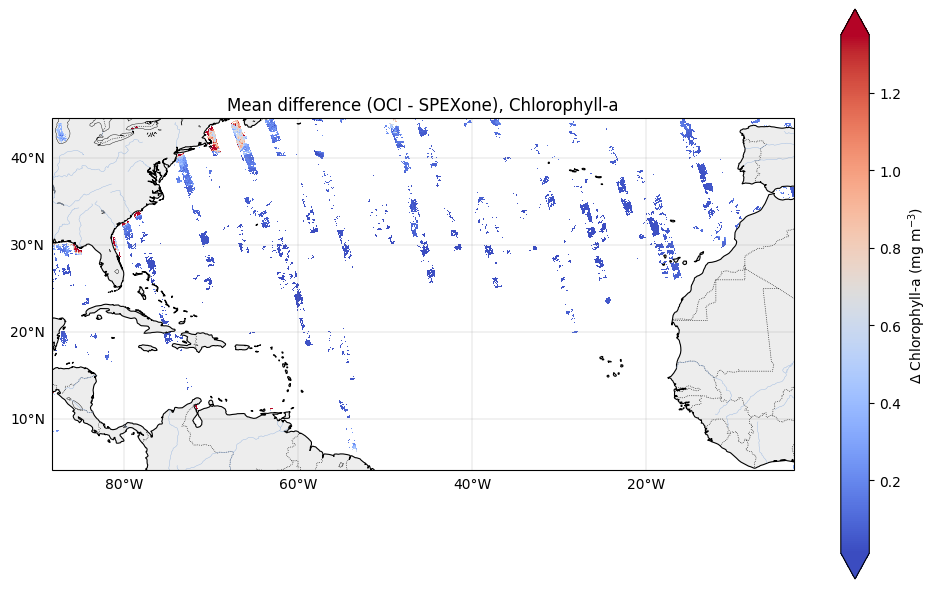

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Compute the time-mean difference
diff = (da_oci_resampled - da_spx_resampled).mean(dim='time')

# Plot with Cartopy projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot the data
im = diff.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # tell xarray how to interpret lon/lat
    cmap='coolwarm',
    cbar_kwargs={'label': r'$\Delta$ Chlorophyll-a (mg m$^{-3}$)'},
    robust=True
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', linewidth=0.3)
ax.add_feature(cfeature.RIVERS, linewidth=0.3)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add a title
ax.set_title("Mean difference (OCI - SPEXone), Chlorophyll-a", fontsize=12)

plt.tight_layout()
plt.show()

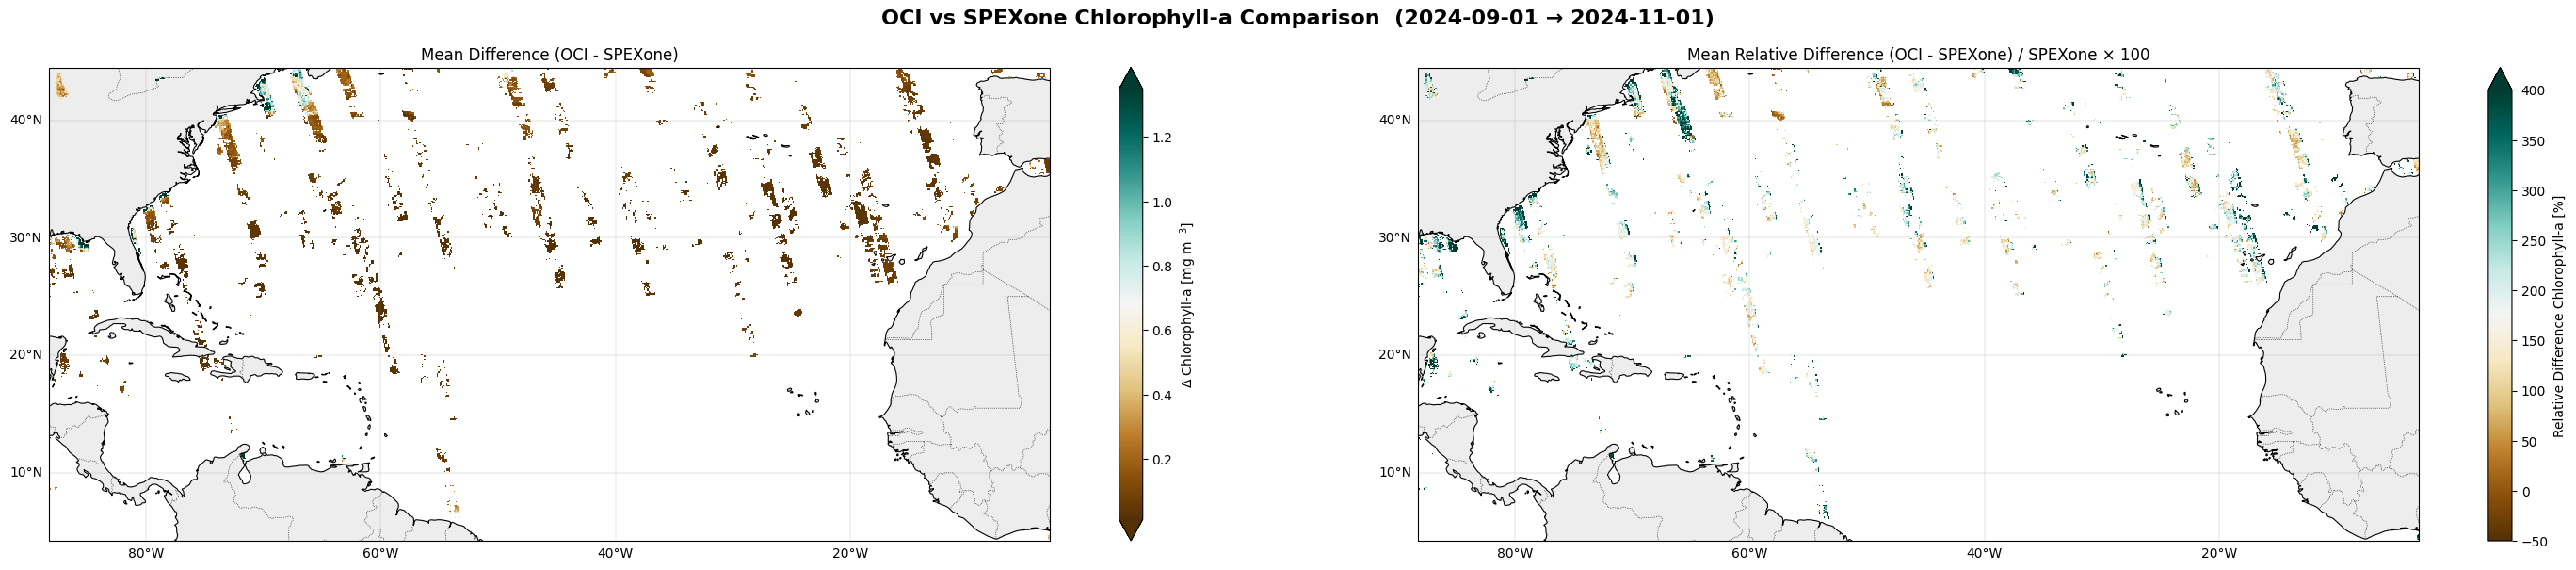

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Compute mean differences ---
diff = (da_oci_resampled - da_spx_resampled).mean(dim='time')

# Avoid division by zero or NaNs for relative difference
rel_diff = ((da_oci_resampled - da_spx_resampled) / da_spx_resampled * 100).mean(dim='time')

# --- Create figure with 2 subplots ---
fig, axes = plt.subplots(
    1, 2,
    figsize=(30, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# === Absolute difference ===
im1 = diff.plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    cbar_kwargs={'label': r'$\Delta$ Chlorophyll-a [mg m$^{-3}$]'},
    robust=True
)
axes[0].add_feature(cfeature.COASTLINE, linewidth=0.8)
axes[0].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
axes[0].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
axes[0].set_title("Mean Difference (OCI - SPEXone)", fontsize=12)

# === Relative difference ===
im2 = rel_diff.plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    cbar_kwargs={'label': 'Relative Difference Chlorophyll-a [%]'},
    robust=True,
    vmin=-50,
    vmax=400
)
axes[1].add_feature(cfeature.COASTLINE, linewidth=0.8)
axes[1].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
axes[1].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
axes[1].set_title("Mean Relative Difference (OCI - SPEXone) / SPEXone × 100", fontsize=12)

# Optional: set regional extent
for ax in axes:
    ax.set_extent([-88.25, -3.0, 4.2, 44.5], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    # Save to output folder
    
    # --- Add a global (super) title with LaTeX ---
fig.suptitle(
    rf"OCI vs SPEXone Chlorophyll-a Comparison  ({tspan_str})",
    fontsize=16,
    fontweight='bold',
    y=0.98
)
out_path = os.path.join(out_dir, f"diff_OCI_SPX.png")
plt.tight_layout(rect=[0, 0, 1, 0.96])  # make space for the suptitle
plt.savefig(out_path, dpi=150,  bbox_inches='tight')
plt.show()

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Intersect both by their shared time coordinate
common_time = da_spx_resampled.time.to_index().intersection(da_oci_resampled.time.to_index())

da_spx_common = da_spx_resampled.sel(time=common_time)
da_oci_common = da_oci_resampled.sel(time=common_time)

mask = (da_spx_common >= 0) & (da_oci_common >= 0)
da_spx_common = da_spx_common.where(mask)
da_oci_common = da_oci_common.where(mask)

In [30]:
# Convert to 1D arrays
data_spx = da_spx_common.values.ravel()
data_oci = da_oci_common.values.ravel()

# Build a mask for valid (non-NaN) entries in both arrays
mask = ~np.isnan(data_spx) & ~np.isnan(data_oci)

# Apply the mask
data_spx = data_spx[mask]
data_oci = data_oci[mask]

In [31]:

df = pd.DataFrame({
    'SPEXone': data_spx,
    'OCI': data_oci
})

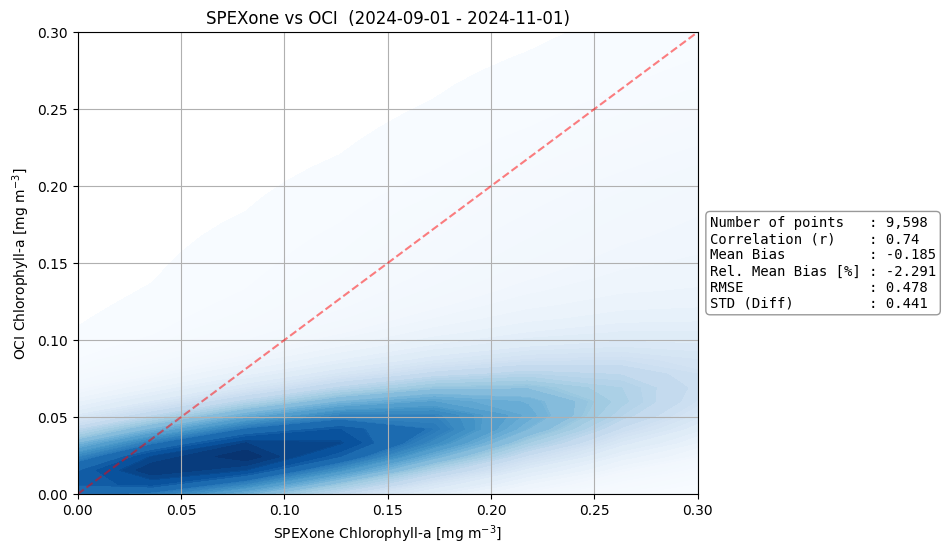

In [41]:
# Compute summary statistics
n_points = len(df)
corr = df['SPEXone'].corr(df['OCI'])

# Difference metrics
diff = df['SPEXone'] - df['OCI']
mean_bias = diff.mean()
rmse = np.sqrt((diff**2).mean())
std_diff = diff.std()
rel_mean_bias = ( ( df['SPEXone'] - df['OCI'] ) / df['SPEXone'] ).mean()
# KDE plot setup
vmin = 0
vmax = 0.3

fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(
    data=df,
    x='OCI',
    y='SPEXone',
    ax=ax,
    fill=True,
    thresh=0.05,
    levels=50,
    cmap='Blues',
)

# Diagonal reference line
ax.plot([vmin, vmax], [vmin, vmax], 'r--', alpha=0.5)

# Axis settings
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_title(f"SPEXone vs OCI  ({tspan_str})")
ax.set_xlabel("SPEXone Chlorophyll-a [mg m$^{-3}$]")
ax.set_ylabel("OCI Chlorophyll-a [mg m$^{-3}$]")
ax.grid(True)

# 📊 Add a text box with updated statistics
stats = {
    "Number of points": f"{n_points:,}",
    "Correlation (r)": f"{corr:.2f}",
    "Mean Bias": f"{mean_bias:.3f}",
    "Rel. Mean Bias [%]": f"{rel_mean_bias:.3f}",
    "RMSE": f"{rmse:.3f}",
    "STD (Diff)": f"{std_diff:.3f}",
}

#label_width = 40# max(len(k) for k in stats.keys()) + 1  # find longest label
label_width = max(len(k) for k in stats.keys()) + 1
textstr = "\n".join(f"{k:<{label_width}}: {v}" for k, v in stats.items())

# Example of displaying it inside a plot:
ax.text(
    1.02, 0.5, textstr,
    transform=ax.transAxes,
    fontsize=10,
    fontfamily='monospace',  # 👈 ensures perfect alignment
    va='center', ha='left',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
)
out_path = os.path.join(out_dir, f"comp_OCI_SPX.png")
#plt.tight_layout(rect=[0, 0, 1, 0.96])  # make space for the suptitle
plt.savefig(out_path, dpi=150,  bbox_inches='tight')
plt.show()

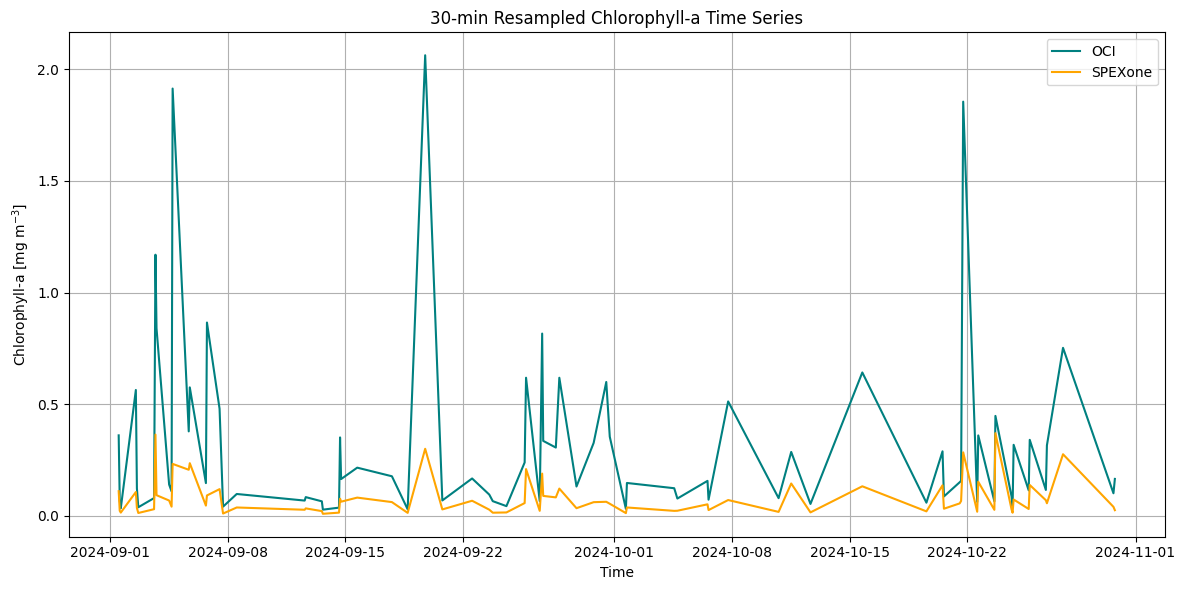

In [43]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Compute global means (if data is 2D+time)
oci_mean = da_oci_common.mean(('lat', 'lon'))
spx_mean = da_spx_common.mean(('lat', 'lon'))

# Mask invalid values
mask = np.isfinite(oci_mean) & np.isfinite(spx_mean)

# Extract time and values
time = oci_mean['time'].values[mask]
oci_vals = oci_mean.values[mask]
spx_vals = spx_mean.values[mask]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(time, oci_vals, label='OCI', color='teal')
plt.plot(time, spx_vals, label='SPEXone', color='orange')
plt.xlabel('Time')
plt.ylabel('Chlorophyll-a [mg m$^{-3}$]')
plt.title('30-min Resampled Chlorophyll-a Time Series')
plt.legend()

plt.grid(True)
plt.tight_layout()
out_path = os.path.join(out_dir, f"time_series_OCI_SPX.png")
plt.savefig(out_path, dpi=150,  bbox_inches='tight')
plt.show()

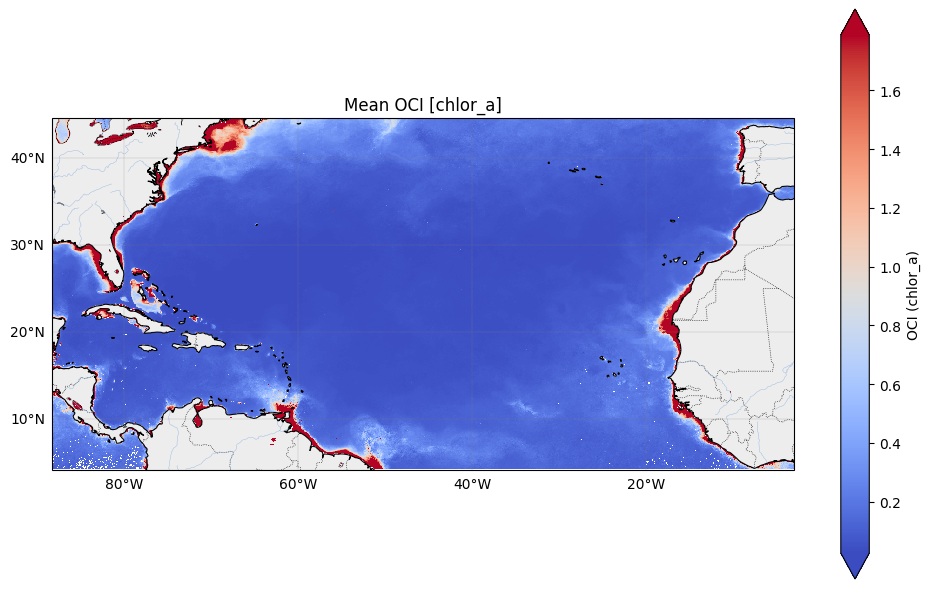

In [ ]:
# Plot with Cartopy projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot the data
im = da_oci_resampled.mean(dim='time').plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # tell xarray how to interpret lon/lat
    cmap='coolwarm',
    cbar_kwargs={'label': 'OCI (chlor_a)'},
    robust=True
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', linewidth=0.3)
ax.add_feature(cfeature.RIVERS, linewidth=0.3)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add a title
ax.set_title("Mean OCI [chlor_a]", fontsize=12)

plt.tight_layout()
plt.show()

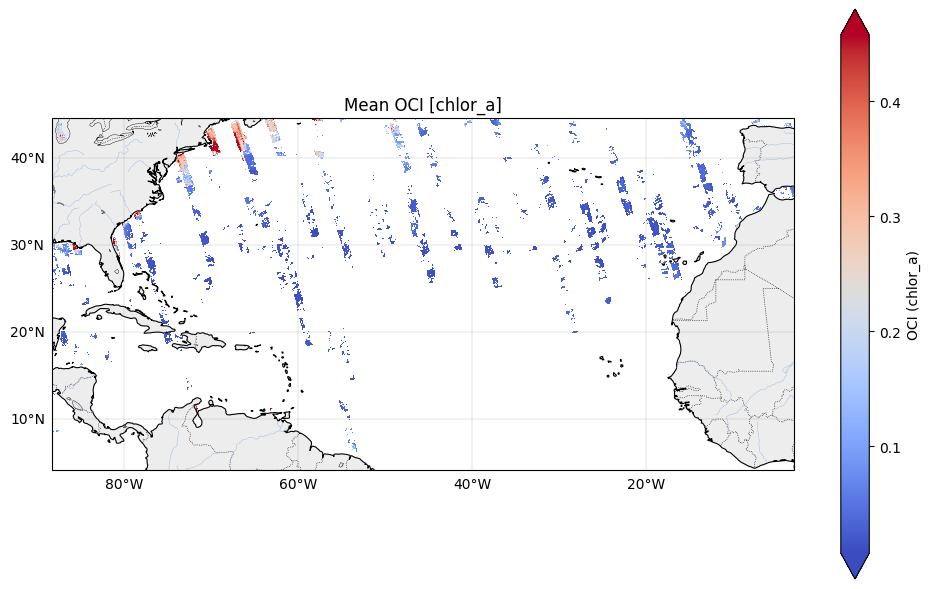

In [ ]:
# Plot with Cartopy projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Plot the data
im = da_spx_resampled.mean(dim='time').plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  # tell xarray how to interpret lon/lat
    cmap='coolwarm',
    cbar_kwargs={'label': 'OCI (chlor_a)'},
    robust=True
)

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', linewidth=0.3)
ax.add_feature(cfeature.RIVERS, linewidth=0.3)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Add a title
ax.set_title("Mean OCI [chlor_a]", fontsize=12)

plt.tight_layout()
plt.show()

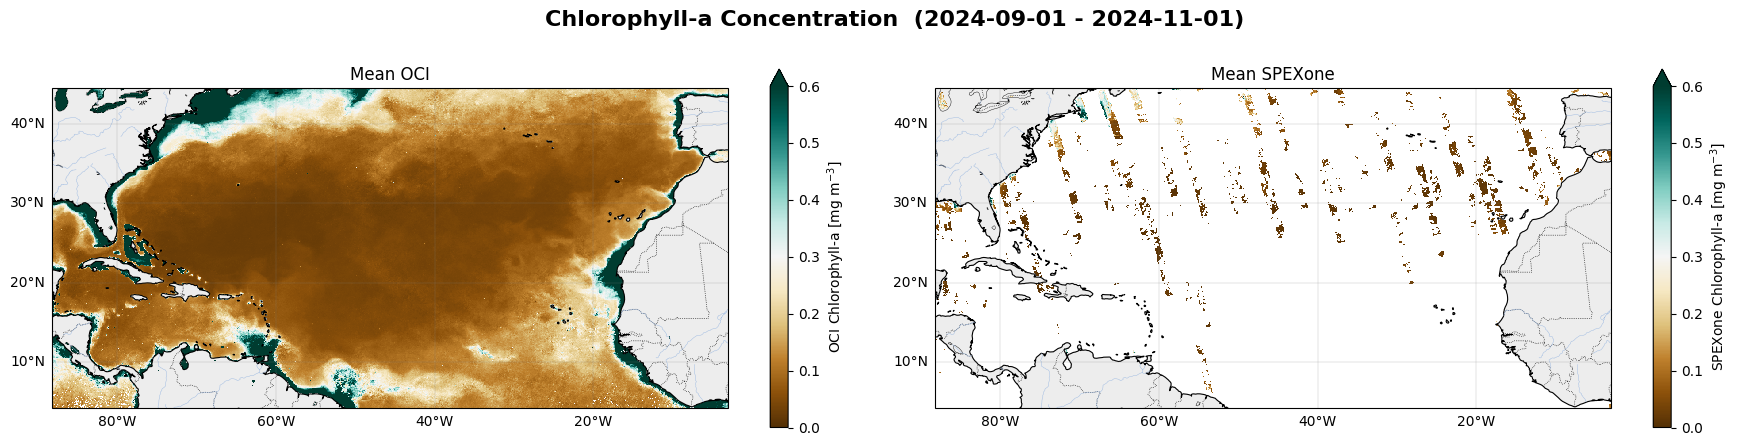

In [52]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Create a 1x2 subplot layout ---
fig, axes = plt.subplots(
    1, 2,
    figsize=(18, 4.5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# === Plot 1: OCI ===
da_oci_resampled.mean(dim='time').plot(
    ax=axes[0],
    transform=ccrs.PlateCarree(),
    cmap='BrBG',  # colorblind-safe diverging colormap
    vmin=0, vmax=0.6,
    cbar_kwargs={'label': 'OCI Chlorophyll-a [mg m$^{-3}$]'}
)

axes[0].add_feature(cfeature.COASTLINE, linewidth=0.8)
axes[0].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
axes[0].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
axes[0].add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', linewidth=0.3)
axes[0].add_feature(cfeature.RIVERS, linewidth=0.3)
axes[0].set_title("Mean OCI", fontsize=12)

gl = axes[0].gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# === Plot 2: SPEXone ===
da_spx_resampled.mean(dim='time').plot(
    ax=axes[1],
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    vmin=0, vmax=0.6,
    cbar_kwargs={'label': 'SPEXone Chlorophyll-a [mg m$^{-3}$]'}
)

axes[1].add_feature(cfeature.COASTLINE, linewidth=0.8)
axes[1].add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
axes[1].add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
axes[1].add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', linewidth=0.3)
axes[1].add_feature(cfeature.RIVERS, linewidth=0.3)
axes[1].set_title("Mean SPEXone", fontsize=12)

gl = axes[1].gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# --- Match map extents ---
for ax in axes:
    ax.set_extent([-88.25, -3.0, 4.2, 44.5], crs=ccrs.PlateCarree())

# --- Add global title ---
fig.suptitle(
    rf"Chlorophyll-a Concentration  ({tspan_str})",
    fontsize=16,
    fontweight='bold',
    y=0.98
)

# --- Layout and save ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
out_path = os.path.join(out_dir, "OCI_SPX_vmax0p6.png")
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()


In [23]:
da_oci = xr.open_mfdataset('/work/chla_NAO/oci_L3M_processed/oci_interp_0.1deg.nc', concat_dim='time', combine='nested')['chlor_a']
da_oci = da_oci.where(da_oci != 0).load()
da_oci_resampled_daily = da_oci.resample(time="2d").mean()
# Drop timesteps where all spatial values are NaN
da_oci_resampled_daily = da_oci_resampled_daily.where(
    ~da_oci_resampled_daily.isnull().all(dim=("lat", "lon")),
    drop=True
)

KeyboardInterrupt: 

KeyboardInterrupt: 

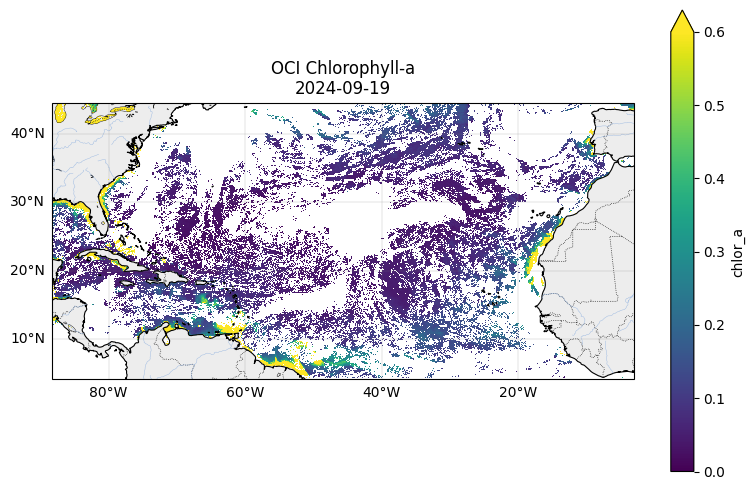

In [22]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np
import os
# --- Create a temporary folder for frames ---
frames_dir = "/work/chla_NAO/frames"
os.makedirs(frames_dir, exist_ok=True)

# --- Generate frames ---
for i, t in enumerate(da_oci_resampled_daily.time.values):
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())  # ✅ Cartopy axis
    
    # Plot the chlorophyll data
    da_oci_resampled_daily.sel(time=t).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        vmin=0,
        vmax=0.6,
        add_colorbar=True
    )
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
    ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black', linewidth=0.3)
    ax.add_feature(cfeature.RIVERS, linewidth=0.3)

    # Optional: gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(f"OCI Chlorophyll-a\n{np.datetime_as_string(t, unit='D')}")
    plt.tight_layout()
    frame_path = f"{frames_dir}/frame_{i:03d}.png"
    plt.savefig(frame_path, dpi=100)
    plt.close(fig)

# --- Create the GIF ---
frames = [imageio.imread(f"{frames_dir}/frame_{i:03d}.png") for i in range(len(da_oci_resampled_daily.time))]
imageio.mimsave("oci_daily.gif", frames, duration=0.4)  # duration = 0.2s per frame

print("✅ GIF saved as oci_daily.gif")